In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [3]:
data_path = Path("../data/ushichka")

In [4]:
# from src.pyushichka.load_data import download_raw
# download_raw(data_path)

In [5]:

from src.pyushichka.load_data import loadImage, loadImageUndistorted, loadCalibration

In [6]:
recording = "2018-08-19"
images = [loadImageUndistorted(cam,0, str(data_path / recording )) for cam in range(0,3)]
calibrations = [loadCalibration(cam, str(data_path / recording)) for cam in range(0,3)]

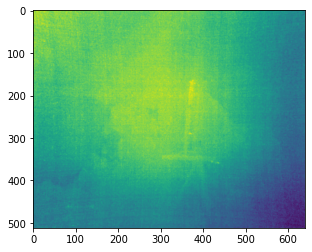

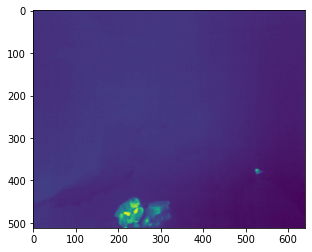

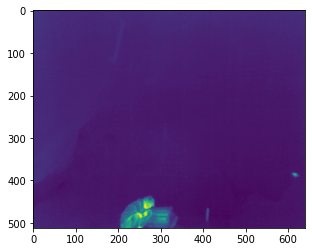

[None, None, None]

In [7]:
import matplotlib.pyplot as plt

def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

[show_img(x) for x in images]

In [8]:
import imageio
import numpy as np

In [9]:
def convert_grayscale_png(img):
    rgb_grayscale = np.zeros(shape=(img.shape[0], img.shape[1], 3))
    for i in range(0,rgb_grayscale.shape[2]):
        rgb_grayscale[:,:,i] = img

    maxv = img.max()
    minv = img.min()

    rgb_grayscale = (rgb_grayscale - minv) / float(maxv-minv)
    rgb_grayscale.max(), rgb_grayscale.min()
    rgb_grayscale = rgb_grayscale * 255
    return rgb_grayscale.astype(np.uint8)

In [10]:
img = convert_grayscale_png(images[0])[:,:,0]
img

array([[224, 221, 234, ..., 128, 129, 139],
       [222, 225, 230, ..., 121, 126, 134],
       [223, 223, 226, ..., 115, 122, 124],
       ...,
       [108, 105, 105, ...,  22,  24,  22],
       [109, 102, 104, ...,  23,  14,  13],
       [117, 106, 109, ...,  26,  16,   8]], dtype=uint8)

In [11]:
Path("../data/images/").mkdir(exist_ok=True)
for i in range(len(images)):
    imageio.imwrite(f"../data/images/image_0{i}.png",convert_grayscale_png(images[i]))

# DMCP

In [12]:
from src.experiment import Experiment

In [13]:
!pwd

/home/julian/code/uni/dmcp/notebooks


In [14]:
import matplotlib as mpl
mpl.use("TKAgg")
exp_path = Path("../data/dmcp/")
exp_path.mkdir(exist_ok=True)


In [22]:

transformations = []
exp = Experiment(str(exp_path), mesh_path="../data/ushichka/lidar_roi.ply")



repeat below cell often (e.g. n=10) times for robust estimation

In [31]:
camera_index = 0
exp.save_imIm(images[camera_index])
exp.save_imK(calibrations[camera_index][0])
exp.save_imP(calibrations[camera_index][1])
exp.exec_dmcp()
trans = exp.load_transform()
transformations.append(trans)

reading mesh
generating depth map
[[      0.60      -0.00      -0.80       0.41]
 [      0.80       0.07       0.60       0.34]
 [      0.06      -1.00       0.04       0.16]]
[[      0.60       0.00       0.80]
 [      0.80      -0.07      -0.60]
 [      0.06       1.00      -0.04]]
[[      0.41]
 [      0.34]
 [      0.16]]
annotate points
executing sparse correspondence alignment (SCA)
estimated pose
[[      0.37      -0.18      -0.91      -0.61]
 [      0.93       0.07       0.36       2.49]
 [      0.00      -0.98       0.19       0.00]]
scale factor 1.0000000000000004
0.9999999999999294
transformation
[[     -0.79       0.61       0.03      -3.27]
 [     -0.61      -0.79       0.01       2.30]
 [      0.04      -0.01       1.00       1.04]
 [      0.00       0.00       0.00       1.00]]


In [32]:
len(transformations)

5

transform to vector of rotation euler values and translation scaled to minmax for outlier detection and centroid computation for robustness

In [60]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.transform import Rotation

def transform_to_vector(transforms):
    vectors = []
    for transform in transforms:
        # Extract rotation matrix
        R = transform[:3, :3]
        # Convert rotation matrix to Euler angles (in radians)
        r = Rotation.from_matrix(R)
        angles = r.as_euler('xyz', degrees=False)  # 'xyz' corresponds to the order of rotations in the rotation matrix
        # Adjust angles to be in the range [-pi, pi]
        angles = np.mod(angles + np.pi, 2 * np.pi) - np.pi
        # Extract translation vector
        t = transform[:3, 3]
        # Concatenate Euler angles and translation into a single vector
        vector = np.concatenate((angles, t))
        vectors.append(vector)
    
    # Min-max scale each dimension independently
    scaler = MinMaxScaler()
    scaled_vectors = scaler.fit_transform(vectors)
    
    return scaled_vectors, scaler

def reverse_transform(vector, scaler):
    # Reverse min-max scaling
    unscaled_vector = scaler.inverse_transform(vector.reshape(1, -1))
    # Split vector into Euler angles and translation components
    unscaled_angles = unscaled_vector[0, :3]
    unscaled_t = unscaled_vector[0, 3:]
    # Adjust angles to be in the range [-pi, pi]
    unscaled_angles = np.mod(unscaled_angles + np.pi, 2 * np.pi) - np.pi
    # Convert Euler angles to rotation matrix
    r = Rotation.from_euler('xyz', unscaled_angles, degrees=False)
    R = r.as_matrix()
    # Combine rotation matrix and translation vector
    transform = np.eye(4)
    transform[:3, :3] = R
    transform[:3, 3] = unscaled_t

    return transform

#tvec, scaler = transform_to_vector(np.array(transformations)[[2,3,4]])
tvec, scaler = transform_to_vector(transformations)
[reverse_transform(t, scaler) for t in tvec]
transformations

[array([[     -0.78,       0.61,       0.12,      -3.09],
        [     -0.62,      -0.78,      -0.08,       2.13],
        [      0.04,      -0.14,       0.99,       0.60],
        [      0.00,       0.00,       0.00,       1.00]]),
 array([[     -0.86,       0.51,       0.00,      -3.63],
        [     -0.51,      -0.86,       0.01,       2.09],
        [      0.01,       0.00,       1.00,       1.06],
        [      0.00,       0.00,       0.00,       1.00]]),
 array([[     -0.72,       0.69,      -0.00,      -3.17],
        [     -0.69,      -0.72,      -0.03,       2.53],
        [     -0.02,      -0.02,       1.00,       0.99],
        [      0.00,       0.00,       0.00,       1.00]]),
 array([[     -0.73,       0.68,       0.11,      -3.26],
        [     -0.68,      -0.73,      -0.02,       2.52],
        [      0.07,      -0.09,       0.99,       0.82],
        [      0.00,       0.00,       0.00,       1.00]]),
 array([[     -0.79,       0.61,       0.03,      -3.27],
      

In [61]:
from sklearn.decomposition import PCA
def detect_inliers(data, n_components=2):
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    pca.fit(data)
    transformed_data = pca.transform(data)

    # Compute Mahalanobis distance for each data point
    cov_matrix = np.cov(transformed_data, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean = np.mean(transformed_data, axis=0)
    distances = np.sqrt(np.sum(np.dot((transformed_data - mean), inv_cov_matrix) * (transformed_data - mean), axis=1))

    # Compute interquartile range
    q1, q3 = np.percentile(distances, [25, 75])
    iqr = q3 - q1

    # Determine inlier threshold
    inlier_threshold = q3 + 1.5 * iqr # 

    # Detect inliers
    inliers_indices = np.where(distances <= inlier_threshold)[0]
    
    # Compute centroid of inliers
    centroid_transformed = np.mean(transformed_data[inliers_indices], axis=0)
    
    # Back-transform centroid to original space
    centroid_original = pca.inverse_transform([centroid_transformed])
    
    return inliers_indices, centroid_original[0]
transformation_vectors = []

inliers, transform = detect_inliers(tvec)
transform = reverse_transform(transform, scaler)

In [62]:
inliers

array([0, 1, 2])

In [63]:
transform

array([[     -0.75,       0.66,       0.05,      -3.23],
       [     -0.66,      -0.75,      -0.01,       2.45],
       [      0.03,      -0.04,       1.00,       0.95],
       [      0.00,       0.00,       0.00,       1.00]])

In [64]:
# save camera 1 for visualization
#transform = transformations[0]
#camera_index = 2
exp = Experiment(str(exp_path), mesh_path="../data/ushichka/lidar_roi.ply")
exp.save_imIm(images[camera_index])
exp.save_imK(calibrations[camera_index][0])
exp.save_imP(calibrations[camera_index][1])
exp.save_transform(transform)
#exp.save_transform(transformations[4])

exp.visualize_3D()

[     -0.60       2.86      -0.11]


In [65]:
import scipy.linalg as la

def transform_projection_matrices(Ps, trans):
    transformed = []
    for P in Ps:
        P_est = P @ la.inv(trans)
        transformed.append(P_est)
    return transformed

transformation = exp.load_transform()
transformed_Ps = transform_projection_matrices([P for K,P in calibrations], transformation)

In [66]:
transformed_Ps

[array([[   -139.73,     594.35,      79.37,   -1773.57],
        [   -341.64,     118.91,    -459.73,    -594.62],
        [     -0.93,       0.29,       0.21,      -1.37]]),
 array([[    -79.48,     610.54,       2.44,      79.55],
        [   -333.99,      92.59,    -471.27,     823.99],
        [     -0.90,       0.41,       0.17,       1.90]]),
 array([[    235.01,     559.41,     104.42,    1064.66],
        [   -237.44,     325.38,    -424.22,     472.11],
        [     -0.58,       0.76,       0.30,       1.65]])]

In [67]:
Ps = transformed_Ps
calib_path = Path("../data/calib")
calib_path.mkdir(exist_ok=True)
[np.savetxt( calib_path / f"P_{i:02d}.csv", Ps[i]) for i in range(len(Ps))]

[None, None, None]